# Visualización

TODO:

* Histograma stacked por número de vícitimas y número de asesinos.
* Resaltar con anotaciones casos importantes
* Mapa con los países. 
* Bubble Clouds con tipo de motivación y país. 
* Diferencia entre las víctimas probadas y probables. lolly pop chart


In [92]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
from scipy.interpolate import splrep, splev

colores = ["#000000", "#3D0000","#950101"," #FF0000", "#6E1722"]
plt.rcParams["figure.dpi"] = 300
plt.rcParams["font.family"] = "Fira Sans Extra Condensed"

plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15)
plt.rc("legend", fontsize = 16)
plt.rc('figure', titlesize=20)
plt.rcParams['axes.titlesize'] = 18

In [93]:
last_kills = pd.DataFrame(data={'año_inicio':[2020] ,'proven_victims':[7]})
last_kills

año_inicio  proven_victims
0        2020               7

In [94]:
serial_killers = pd.read_excel("output/serial_killers.xlsx")
serial_killers = serial_killers.append(last_kills, ignore_index=True)
serial_killers = serial_killers[serial_killers.año_inicio >= 1900]

serial_killers['año'] = pd.to_datetime(serial_killers.año_inicio.map(str) + '-01-01')
serial_killers.columns

Index(['Name', 'pais_1', 'pais_2', 'pais_3', 'año_inicio', 'año_termino',
       'proven_victims', 'possible_victims', 'Notes', 'tipo_asesino',
       'identificado', 'views', 'año'],
      dtype='object')

In [95]:
ts = serial_killers[['año','proven_victims']].groupby('año').sum()
ts

proven_victims
año                       
1900-01-01              55
1905-01-01              10
1906-01-01              36
1907-01-01              33
1908-01-01              12
...                    ...
2011-01-01              71
2014-01-01              10
2015-01-01               9
2016-01-01               7
2020-01-01               7

[87 rows x 1 columns]

# Gráfico línea de tiempo con cantidad de víctimas

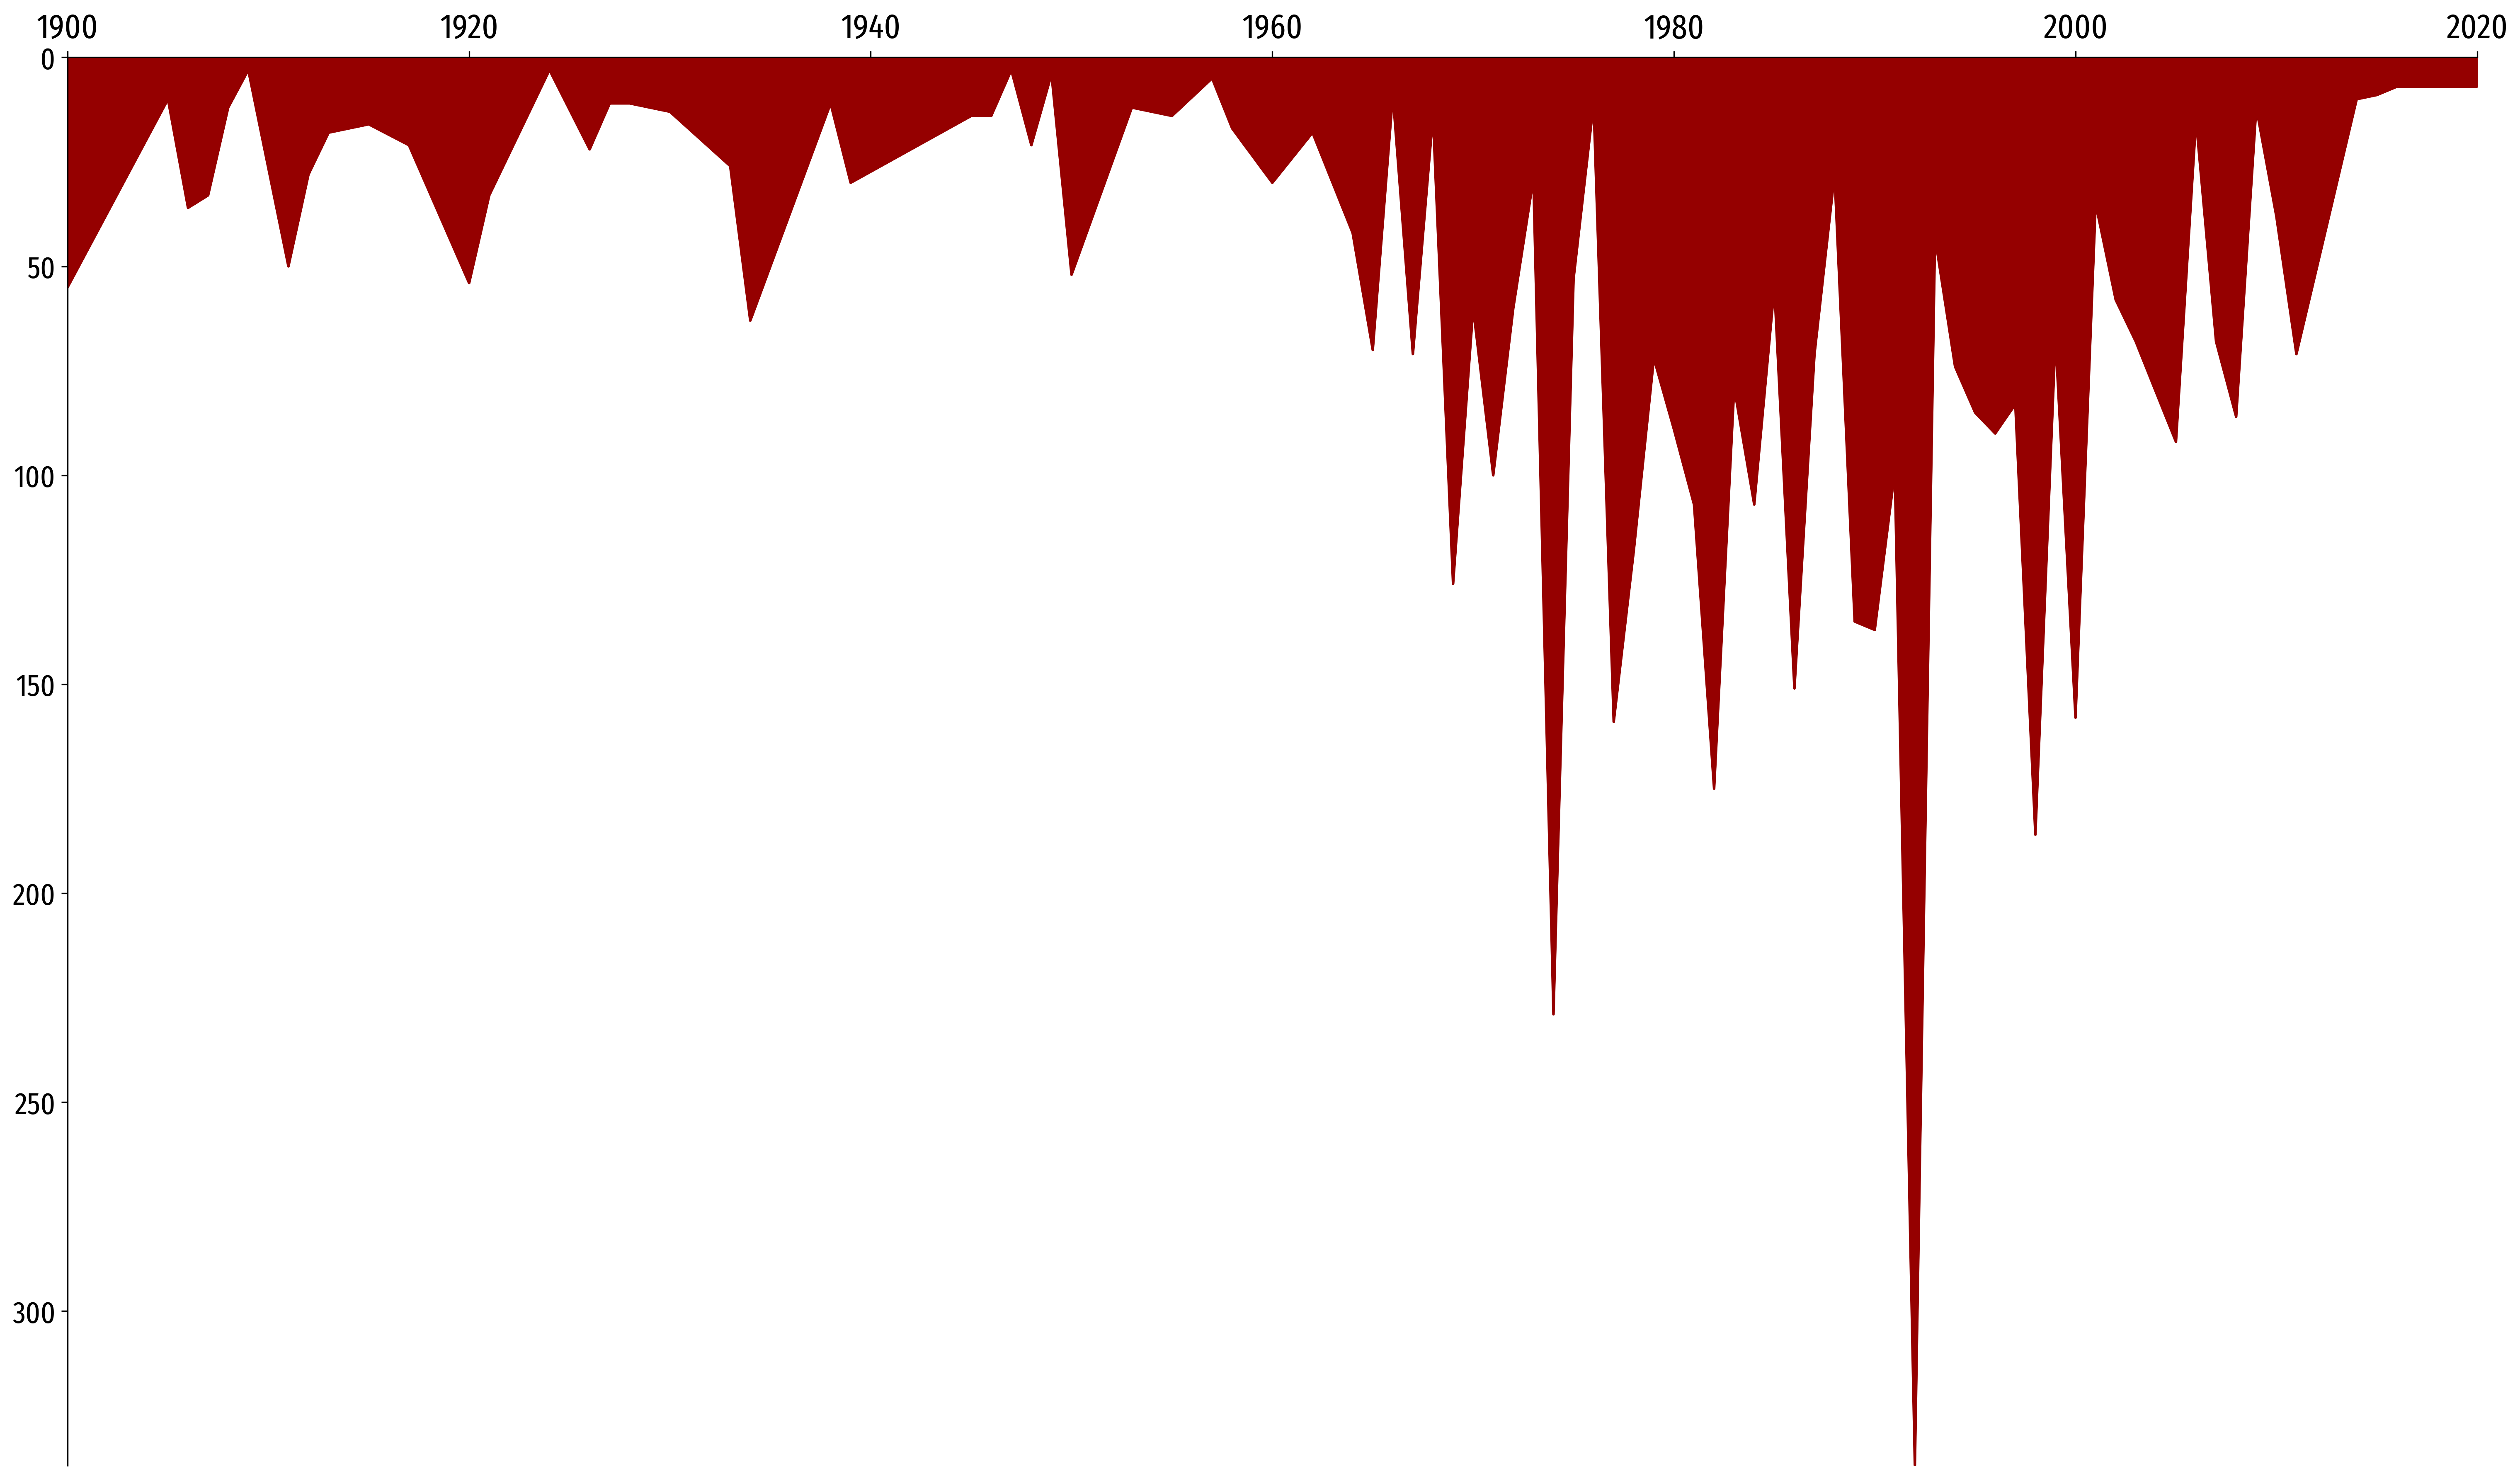

In [96]:
fig = plt.figure(figsize=(25,15), dpi = 300)
ax = fig.add_subplot(1, 1, 1)
ax.xaxis.set_ticks_position('top')
ax.invert_yaxis()
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.xticks(fontsize=20)
plt.yticks(fontsize=18)
ax.margins(0)
plt.xlim(pd.to_datetime('1900-01-01'),pd.to_datetime( '2020-01-01'))
ax.plot(ts.index, ts.proven_victims, linewidth = 1.5, color ='#950000' )
plt.fill_between(ts.index, ts.proven_victims, color = '#950000')#
#plt.savefig('output/vis/hist.svg', transparent=True)

# Gráfico mapa con n° de asesinos en serie

In [97]:
#Mapa en geojson
#mapa = gpd.read_file('https://raw.githubusercontent.com/simonepri/geo-maps/master/previews/countries-coastline.geo.json')
url = 'https://code.highcharts.com/mapdata/custom/world.geo.json'
mapa = gpd.read_file(url)
country_dict = pd.read_excel("output/country_dict.xlsx")
mapa = mapa[['iso-a3', 'geometry']]
mapa = mapa.rename(columns={'iso-a3':'A3'})

In [98]:
country_dict = country_dict.merge(mapa, on='A3')
country_dict

name   A3  \
0              Afghanistan  AFG   
1                  Albania  ALB   
2                  Algeria  DZA   
3           American Samoa  ASM   
4                  Andorra  AND   
..                     ...  ...   
199  Virgin Islands (U.S.)  VIR   
200         Western Sahara  ESH   
201                  Yemen  YEM   
202                 Zambia  ZMB   
203               Zimbabwe  ZWE   

                                              geometry  
0    POLYGON ((6426.000 7631.000, 6411.000 7627.000...  
1    MULTIPOLYGON (((4826.000 7757.000, 4826.000 77...  
2    POLYGON ((4061.000 7231.000, 4040.000 7245.000...  
3    POLYGON ((-859.000 6056.000, -861.000 6055.000...  
4    POLYGON ((4246.000 7818.000, 4255.000 7818.000...  
..                                                 ...  
199  POLYGON ((2283.000 7008.000, 2288.000 7008.000...  
200  POLYGON ((3698.000 7100.000, 3696.000 7103.000...  
201  POLYGON ((5747.000 7045.000, 5769.000 6994.000...  
202  POLYGON ((5050.000 6201.000, 5069.000 6222.000...  
203  POLYGON ((4954.000 5949.000, 4996.000 5940.000...  

[204 rows x 3 columns]

Creo vector de países (hay asesinos en serie que actuaron en más de un país)

In [99]:
paises = serial_killers['pais_1']
paises = paises.append(serial_killers['pais_2'], ignore_index=True)
paises = paises.append(serial_killers['pais_3'], ignore_index=True)
paises = pd.DataFrame(data={'country':paises})
paises = paises[~paises['country'].isnull()]
paises.head()

country
0    Germany
1     Brazil
2   Colombia
3  Swaziland
4      China

In [100]:
n_pais = pd.DataFrame(data = {'count':paises.value_counts('country')})
n_pais.head()

count
country              
United States      98
Russia             48
South Africa       19
Germany            13
United Kingdom     13

In [101]:
n_pais = country_dict.merge(n_pais, how='left',right_index=True, left_on='name').drop('A3', axis=1).set_index('name')

In [102]:
n_pais = gpd.GeoDataFrame(n_pais)
n_pais = n_pais.replace(np.nan, 0)
n_pais = n_pais[(n_pais.index != 'Antarctica' ) & (n_pais.index !='Greenland')]

In [103]:
ceros = n_pais[n_pais['count'] == 0]
ceros = pd.DataFrame(data=ceros.index)

In [193]:
from aves.visualization.maps import choropleth_map
from aves.visualization.figures import figure_from_geodataframe, GeoFacetGrid

/Users/fabianalexis/opt/anaconda3/envs/aves/lib/python3.8/site-packages/seaborn/axisgrid.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)


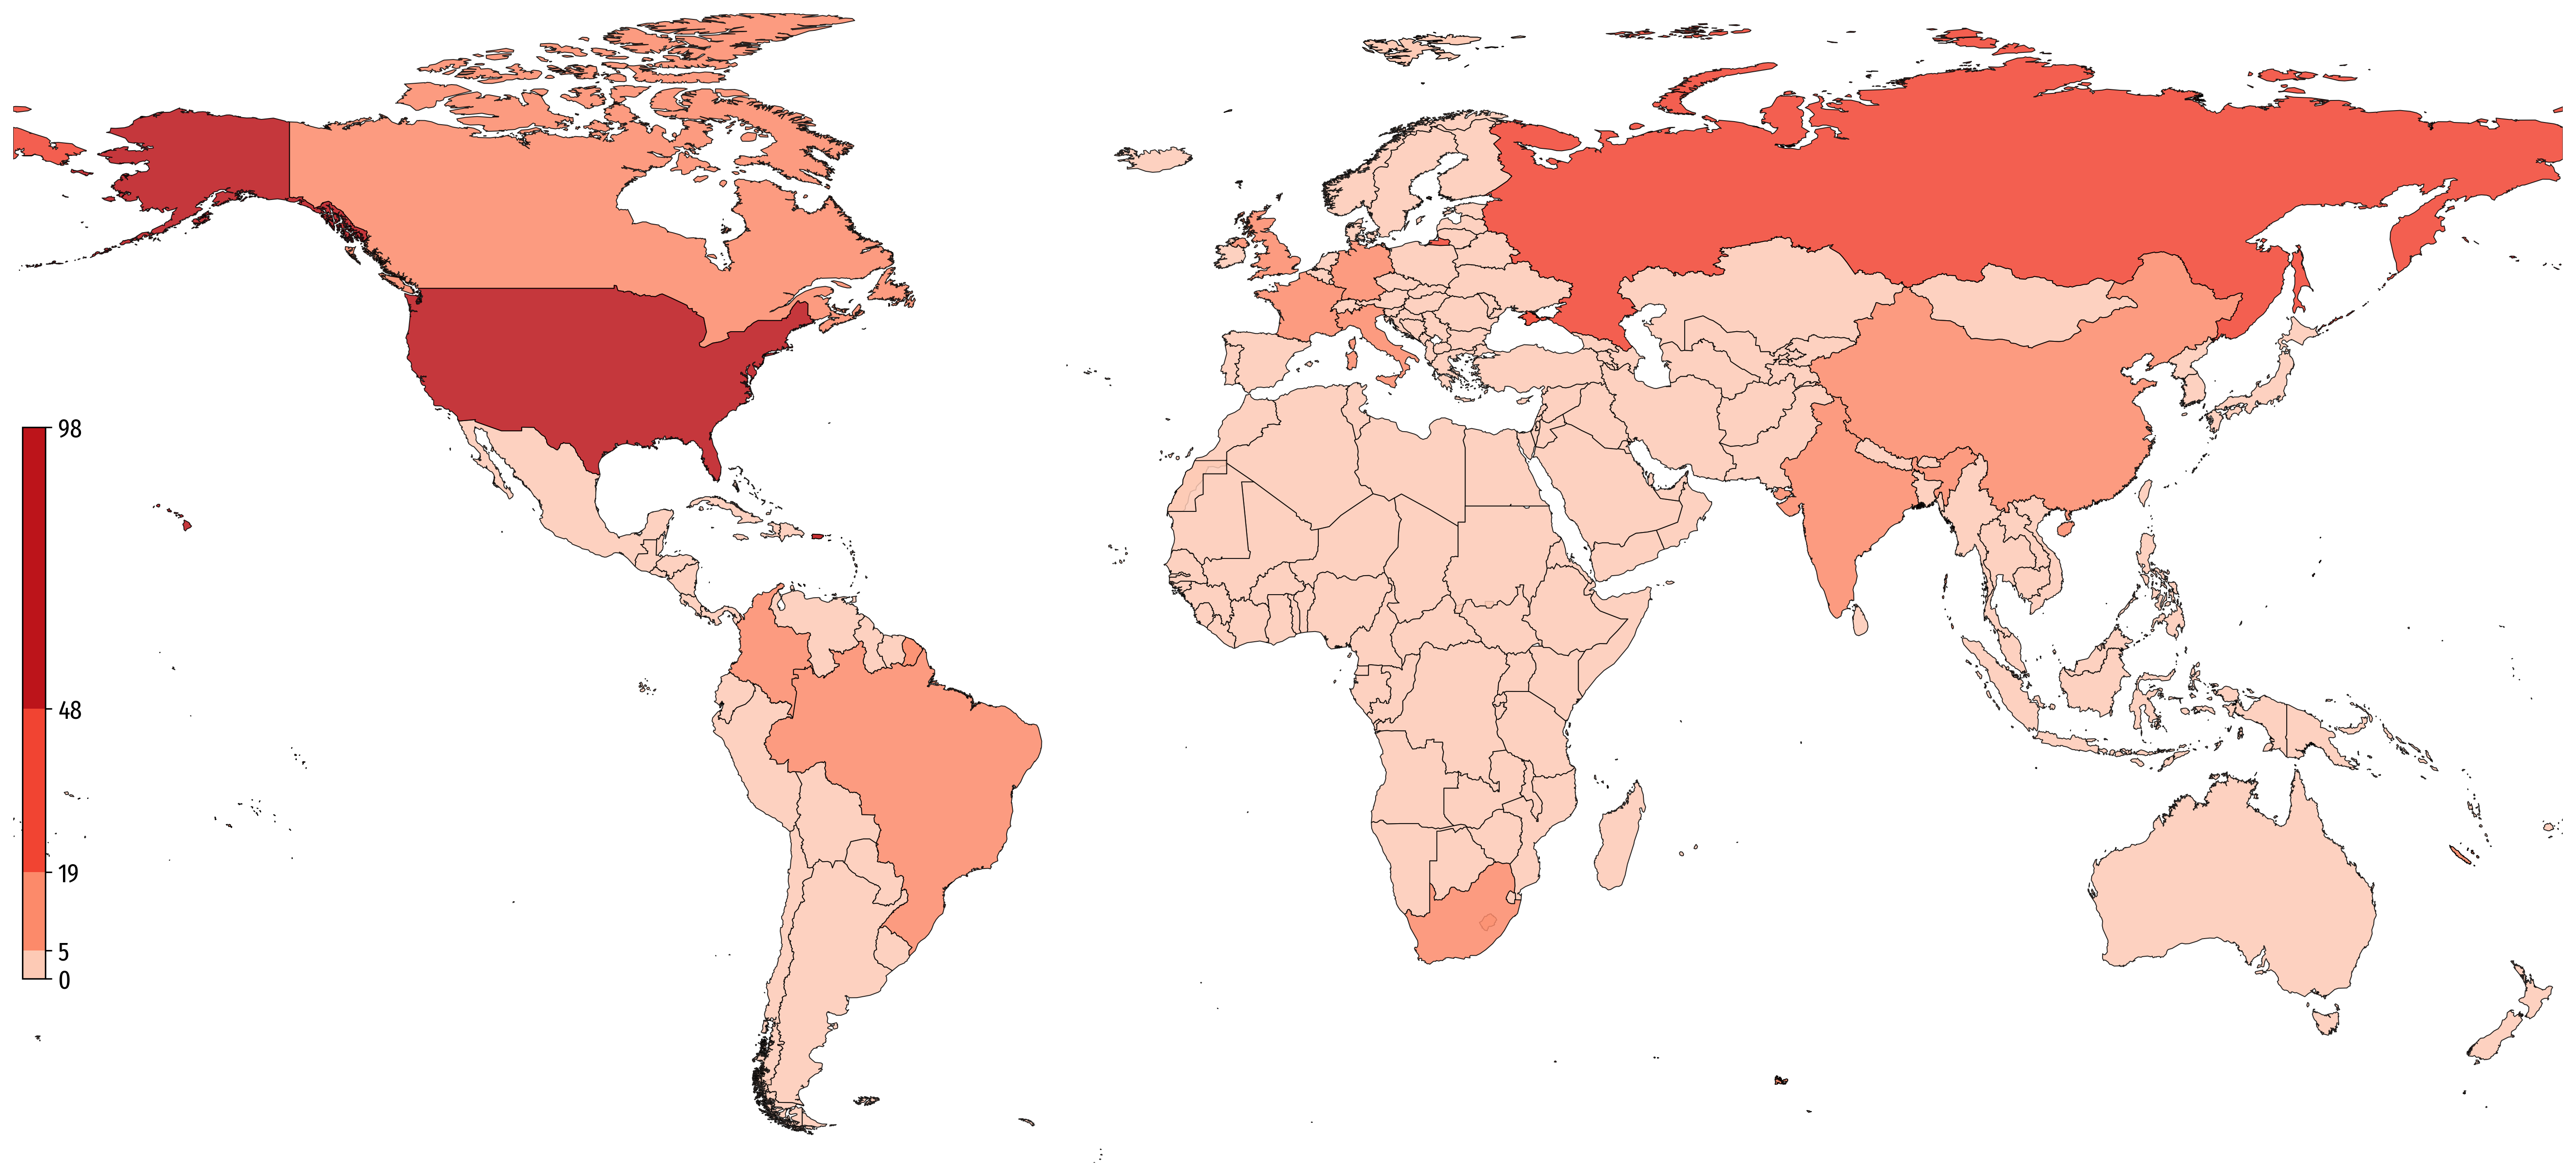

In [342]:
grid = GeoFacetGrid(n_pais, height=9)

#grid.add_basemap() 
grid.add_layer(
    choropleth_map,
    "count",
    k=4,
    linewidth=0.5,
    edgecolor="black",
    binning="fisher_jenks",
    #palette='YlOrRd',
    palette = 'Reds',
    alpha=0.85,
    cbar_args=dict(
        height="60%",
        width="1%",
        orientation="vertical",
        location="center left",
        label_size='x-large',
        bbox_to_anchor=(0, 0.0, 0.9, 0.8),
       # label="N° de asesinos",
    ),
)
#grid.set_title()
grid.tight_layout()
grid.savefig("output/vis/map.svg", transparent=True)

# Bubble Plot

## codigo para bubble dual

In [221]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pymunk
from pymunk.vec2d import Vec2d
import pymunk.matplotlib_util
import numpy as np

from matplotlib.patches import Circle
from matplotlib.collections import PatchCollection
from matplotlib.colors import ListedColormap
import seaborn as sns


def arc_patch(center, radius, theta1, theta2, ax=None, resolution=50, **kwargs):
    # make sure ax is not empty
    if ax is None:
        ax = plt.gca()
    # generate the points
    theta = np.linspace(np.radians(theta1), np.radians(theta2), resolution)
    points = np.vstack((radius*np.cos(theta) + center[0], 
                        radius*np.sin(theta) + center[1]))
    # build the polygon and add it to the axes
    poly = mpatches.Polygon(points.T, closed=True, **kwargs)
    ax.add_patch(poly)
    return poly

def plot_dual_bubble(ax,pos=[0,0],left_percentage=50, radio=1, use_palette=True, palette=None,left_color='#605f5e', right_color='#950000', reverse_color=False):
    
    percentage=left_percentage    
    angle=90-(90/50)*percentage
    if palette is not None and use_palette == True:
        cmap = matplotlib.cm.get_cmap(palette, 2)
        left_color = cmap(0)
        right_color = cmap(1)
    if left_color is None:
        left_color = '#394053'
    if right_color is None:
       right_color = '#950000'
    if reverse_color == True:
        tmp = left_color
        left_color = right_color
        right_color = tmp
    arc_patch((pos[0],pos[1]), radio, 270-angle, 90+angle, ax=ax, fill=True, color=left_color)
    arc_patch((pos[0],pos[1]), radio, -90-angle, 90+angle, ax=ax, fill=True, color=right_color)


def bubble_plot(
    ax,
    df,
    position_column,
    radius_column,
    label_column=None,
    color_column=None,
    palette="plasma",
    n_bins=10,
    num_steps=50,
    x_position_scaling=800,
    min_label_size=4,
    max_label_size=64,
    starting_y_range=None,
    margin=2,
    dual=False,
    dual_reverse_color=False,
    dual_use_palette=None,
    dual_left_color=None,
    dual_right_color=None
):
    df = df.reset_index()
    space = pymunk.Space()
    space.gravity = (0, 0)

    radius = np.sqrt(df[radius_column].values) + margin

    if starting_y_range is None:
        starting_y_range = int(np.sqrt(df.shape[0]))

    for idx, row in df.iterrows():
        x = row[position_column] * x_position_scaling
        y = np.random.randint(-starting_y_range, starting_y_range)
        mass = 10
        r = radius[idx]

        moment = pymunk.moment_for_circle(mass, 0, r, (0, 0))

        body = pymunk.Body(mass, moment)

        body.position = x, y
        body.start_position = Vec2d(*body.position)

        shape = pymunk.Circle(body, r)
        shape.elasticity = 0.9999999

        space.add(body, shape)

    for i in range(num_steps):
        space.step(1)

    value_range = (min(radius), max(radius))

    def scale(value):
        result = (value - value_range[0]) / (value_range[1] - value_range[0])
        return result

    ax.set_aspect("equal")

    cmap = ListedColormap(sns.color_palette(palette, n_colors=n_bins))

    collection = []
    values = []
    min_x = 0
    max_x = 0
    min_y = 0
    max_y = 0

    for body, (idx, row) in zip(space.bodies, df.iterrows()):
        circle = next(iter(body.shapes))
        c = Circle(np.array(body.position), circle.radius - margin)
        collection.append(c)
        values.append(row[position_column])

        body_x = body.position.x
        body_min_x = body_x - circle.radius
        body_max_x = body_x + circle.radius

        body_y = body.position.y
        body_min_y = body_y - circle.radius
        body_max_y = body_y + circle.radius

        if body_min_y < min_y:
            min_y = body_min_y

        if body_min_x < min_x:
            min_x = body_min_x

        if body_max_y > max_y:
            max_y = body_max_y

  
        if body_max_x > max_x:
            max_x = body_max_x

        if dual == True:
            plot_dual_bubble(ax,
                         pos=list(body.position),
                         radio=circle.radius,
                         #left_percentage=100-100*(body.position.x-min_x)/(max_x-min_x)
                         #left_percentage=row.M*100
                         left_percentage= 100-100 * (row[position_column]+1)/2,
                         reverse_color = dual_reverse_color,
                         left_color = dual_left_color,
                         right_color = dual_right_color,
                         palette = palette,
                         use_palette = dual_use_palette
                         )
        if label_column is not None:
            label_size = int(scale(radius[idx]) * max_label_size)
            if label_size < min_label_size:
                continue
            if label_size <= 8:
                label_size = 10
                ax.annotate(
                    row[label_column],
                    np.array(body.position),
                    ha="center",
                    va="center",
                    fontsize=label_size,
                    color = '#fff'
                )
            else: 
                ax.annotate(
                    row[label_column],
                    np.array(body.position),
                    ha="center",
                    va="center",
                    fontsize=label_size,
                    color = '#fff'
                )


    collection = PatchCollection(collection, color="pink", edgecolor="none", cmap=cmap)
    collection.set_array(np.array(values))
    ax.add_collection(collection)

    ax.set_aspect("equal")
    ax.set_xlim([min_x, max_x])
    ax.set_ylim([min_y, max_y])

    return space, collection

In [143]:
from aves.visualization.tables.bubbles import bubble_plot

In [131]:
data = serial_killers.groupby(["pais_1","tipo_asesino"]).size().reset_index(name='counts')
data['tipo_asesino']  = data.tipo_asesino.map(str).replace({"0.0":"Motivación no sexual", "1.0":"Motivación sexual"})
data

pais_1          tipo_asesino  counts
0      Afghanistan  Motivación no sexual       1
1        Argentina     Motivación sexual       3
2        Australia  Motivación no sexual       4
3        Australia     Motivación sexual       1
4          Austria  Motivación no sexual       2
..             ...                   ...     ...
71  United Kingdom     Motivación sexual       7
72   United States  Motivación no sexual      37
73   United States     Motivación sexual      58
74       Venezuela  Motivación no sexual       1
75           Yemen  Motivación no sexual       1

[76 rows x 3 columns]

In [132]:
data_pivot = pd.pivot_table(data, index="pais_1", columns="tipo_asesino", values="counts").fillna(0)

In [136]:
data_pivot['total'] = data_pivot['Motivación no sexual'] + data_pivot['Motivación sexual']
data_pivot['Motivación no sexual'] = data_pivot['Motivación no sexual']/data_pivot['total']
data_pivot['Motivación sexual'] = data_pivot['Motivación sexual']/data_pivot['total']

In [138]:
data_pivot['tendency'] = data_pivot['Motivación sexual']  - data_pivot['Motivación no sexual']

In [165]:
data_pivot = data_pivot. pipe(lambda x: x[x["Motivación sexual"].between(0.02, 0.98)])

In [169]:
data_pivot['total'] = data_pivot['total']*200

/var/folders/l4/br6xdwsn3wj7ntybwy6zwmvh0000gn/T/ipykernel_40544/150511904.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pivot['total'] = data_pivot['total']*200


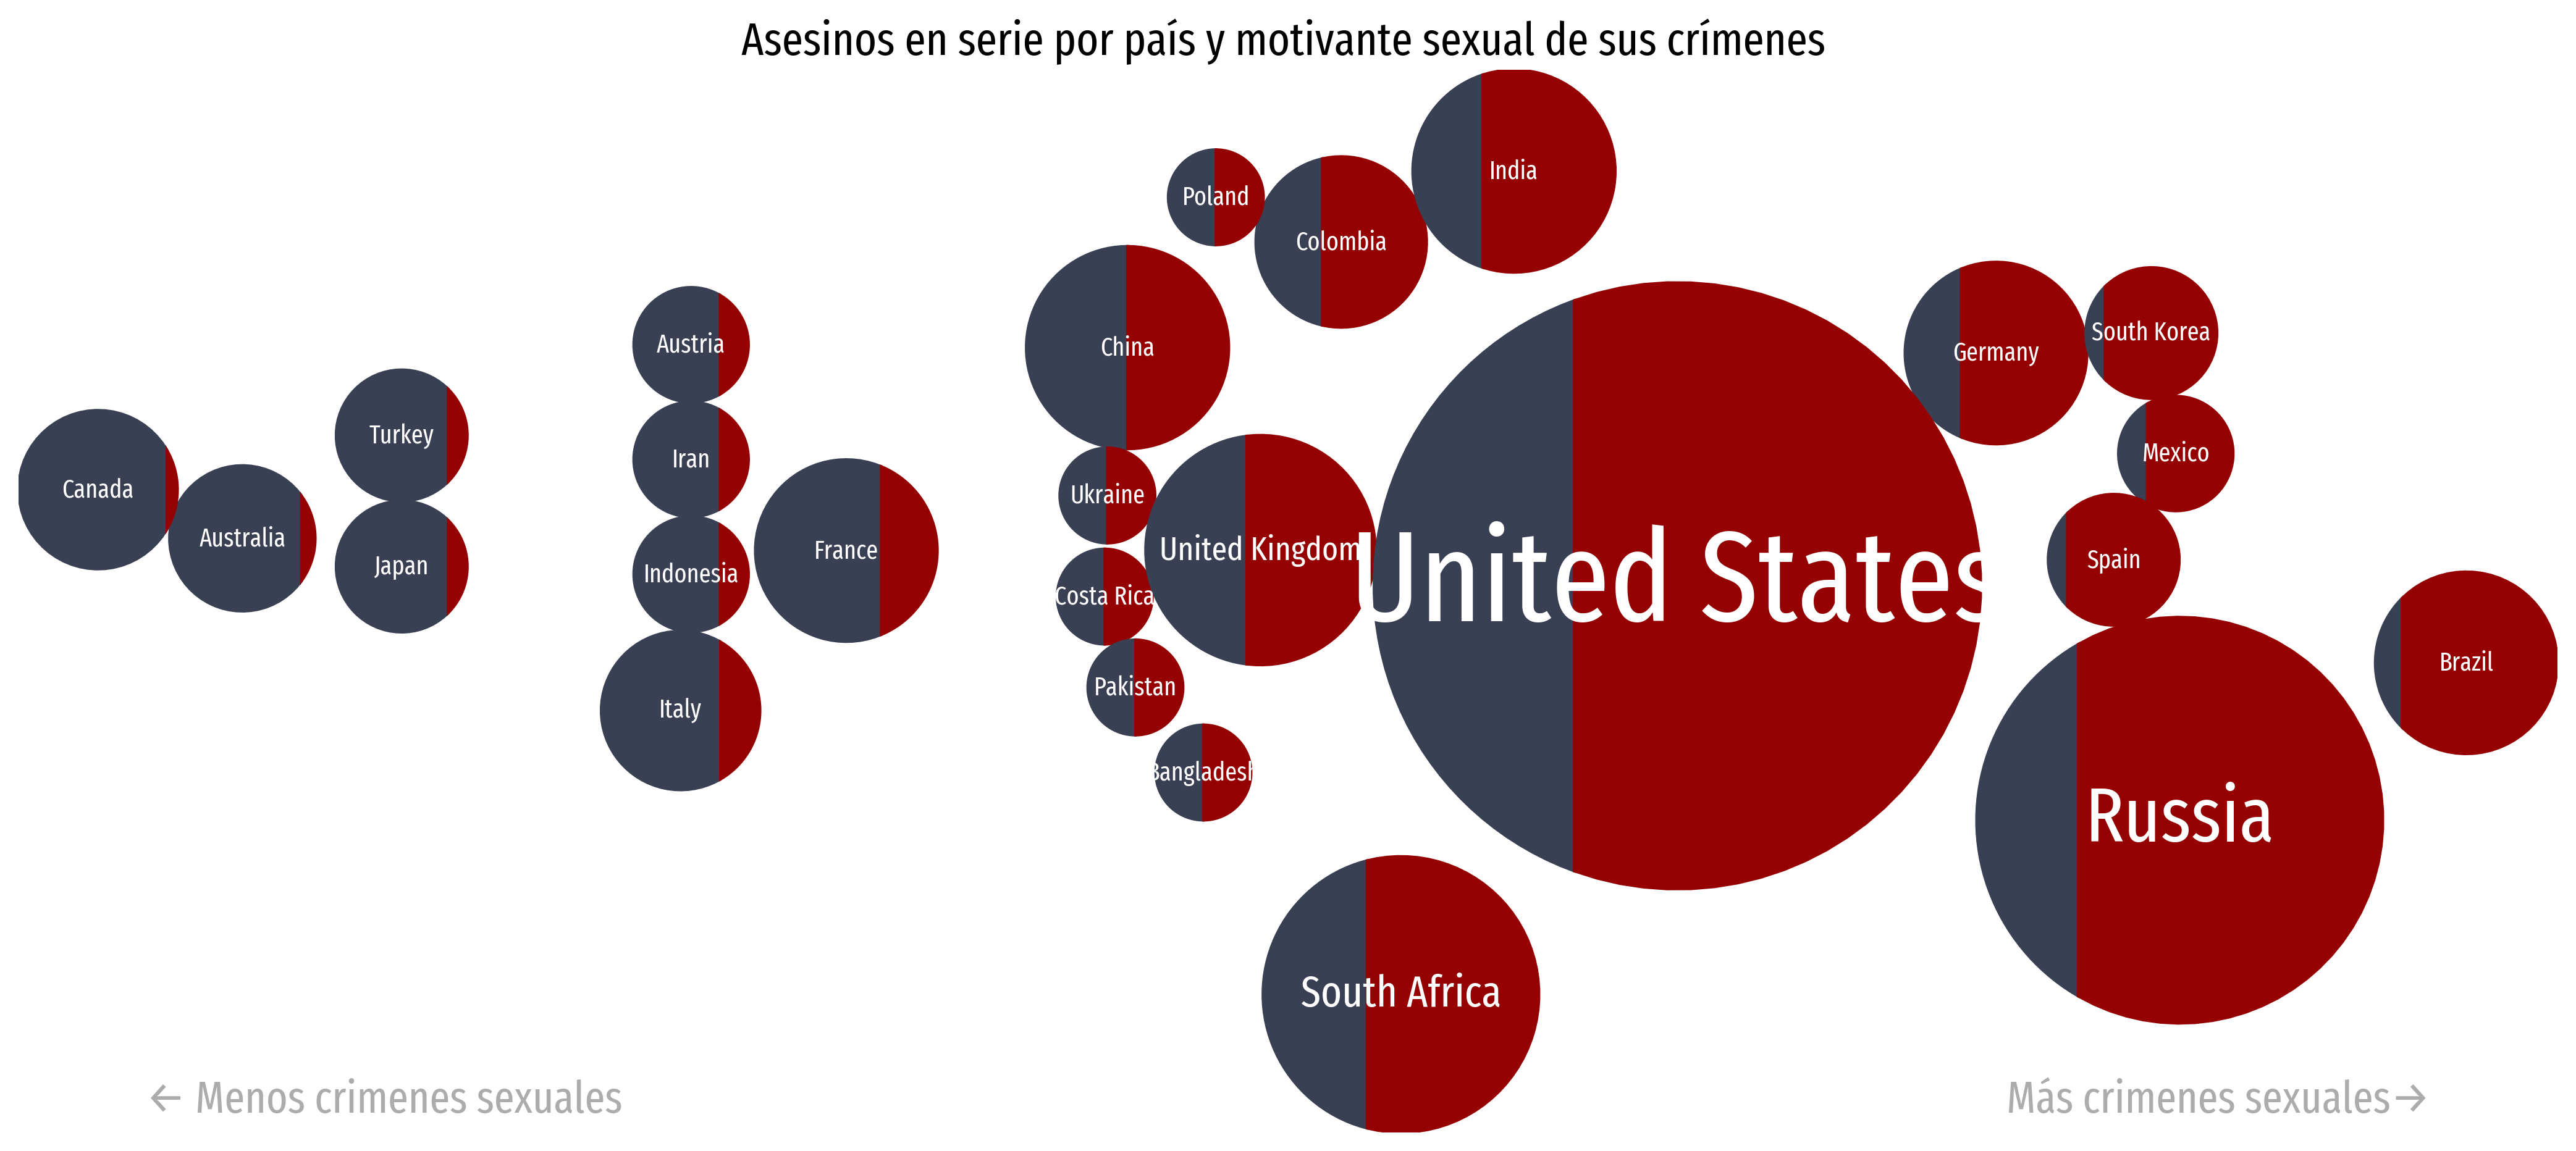

In [233]:
import matplotlib.pyplot as plt
import matplotlib
fig, ax = plt.subplots(figsize=(14, 12), dpi = 300)

bubble_plot(
    ax,
    data_pivot.reset_index(),
    "tendency",
    "total",
    label_column="pais_1",
    palette="cool",
    dual = True,
    dual_reverse_color = False,
    dual_use_palette = False,
    max_label_size=50,
    min_label_size=0,
    starting_y_range=30, margin=2
)

ax.set_axis_off()
ax.set_title(
    "Asesinos en serie por país y motivante sexual de sus crímenes "
)
ax.annotate(
    "Más crimenes sexuales→",
    (0.95, 0.01),
    xycoords="axes fraction",
    ha="right",
    va="bottom",
    fontsize="xx-large",
    color="#abacab",
)
ax.annotate(
    "← Menos crimenes sexuales",
    (0.05, 0.01),
    xycoords="axes fraction",
    ha="left",
    va="bottom",
    fontsize='xx-large',
    color="#abacab",
)

fig.set_facecolor("white")
fig.tight_layout()
plt.savefig("output/vis/bubble_dual.svg", transparent=True)


# Lollypop

In [5]:
serial_killers.head()
ts_2 = serial_killers
ts_2 = serial_killers[ts_2['possible_victims'] - ts_2['proven_victims']  > 5].sort_values('views', ascending=False).head(20)[['Name', 'proven_victims',  'possible_victims']]
ts_2 = ts_2.reset_index().drop("index", axis=1)
ts_2.possible_victims = ts_2.possible_victims.map(int)
ts_2 = ts_2.sort_values('possible_victims')
ts_2

Name  proven_victims  possible_victims
14               Joel Rifkin               9                17
2            Richard Ramirez              13                20
6              Robert Hansen              15                21
9               Carl Panzram               5                22
18           Herb Baumeister              16                25
1              Zodiac Killer               5                37
17  Cleveland Torso Murderer              13                40
13             Belle Gunness              13                40
19               Peter Tobin               3                48
10        Robert Ben Rhoades               3                50
12              Peter Kürten               9                79
15      Donald Henry Gaskins              12                80
3               Gary Ridgway              49                90
7              Samuel Little              60                93
4                Albert Fish               3               100
16     Pedro Rodrigues Filho              71               100
0                  Ted Bundy              35               100
5              Rodney Alcala               8               130
11    Keith Hunter Jesperson               8               160
8              Luis Garavito             138               300

In [6]:
ts_2['possible_victims'] - ts_2['proven_victims']  > 5

14    True
2     True
6     True
9     True
18    True
1     True
17    True
13    True
19    True
10    True
12    True
15    True
3     True
7     True
4     True
16    True
0     True
5     True
11    True
8     True
dtype: bool

In [7]:
my_range=range(1,len(ts_2.index)+1)
my_range

range(1, 21)

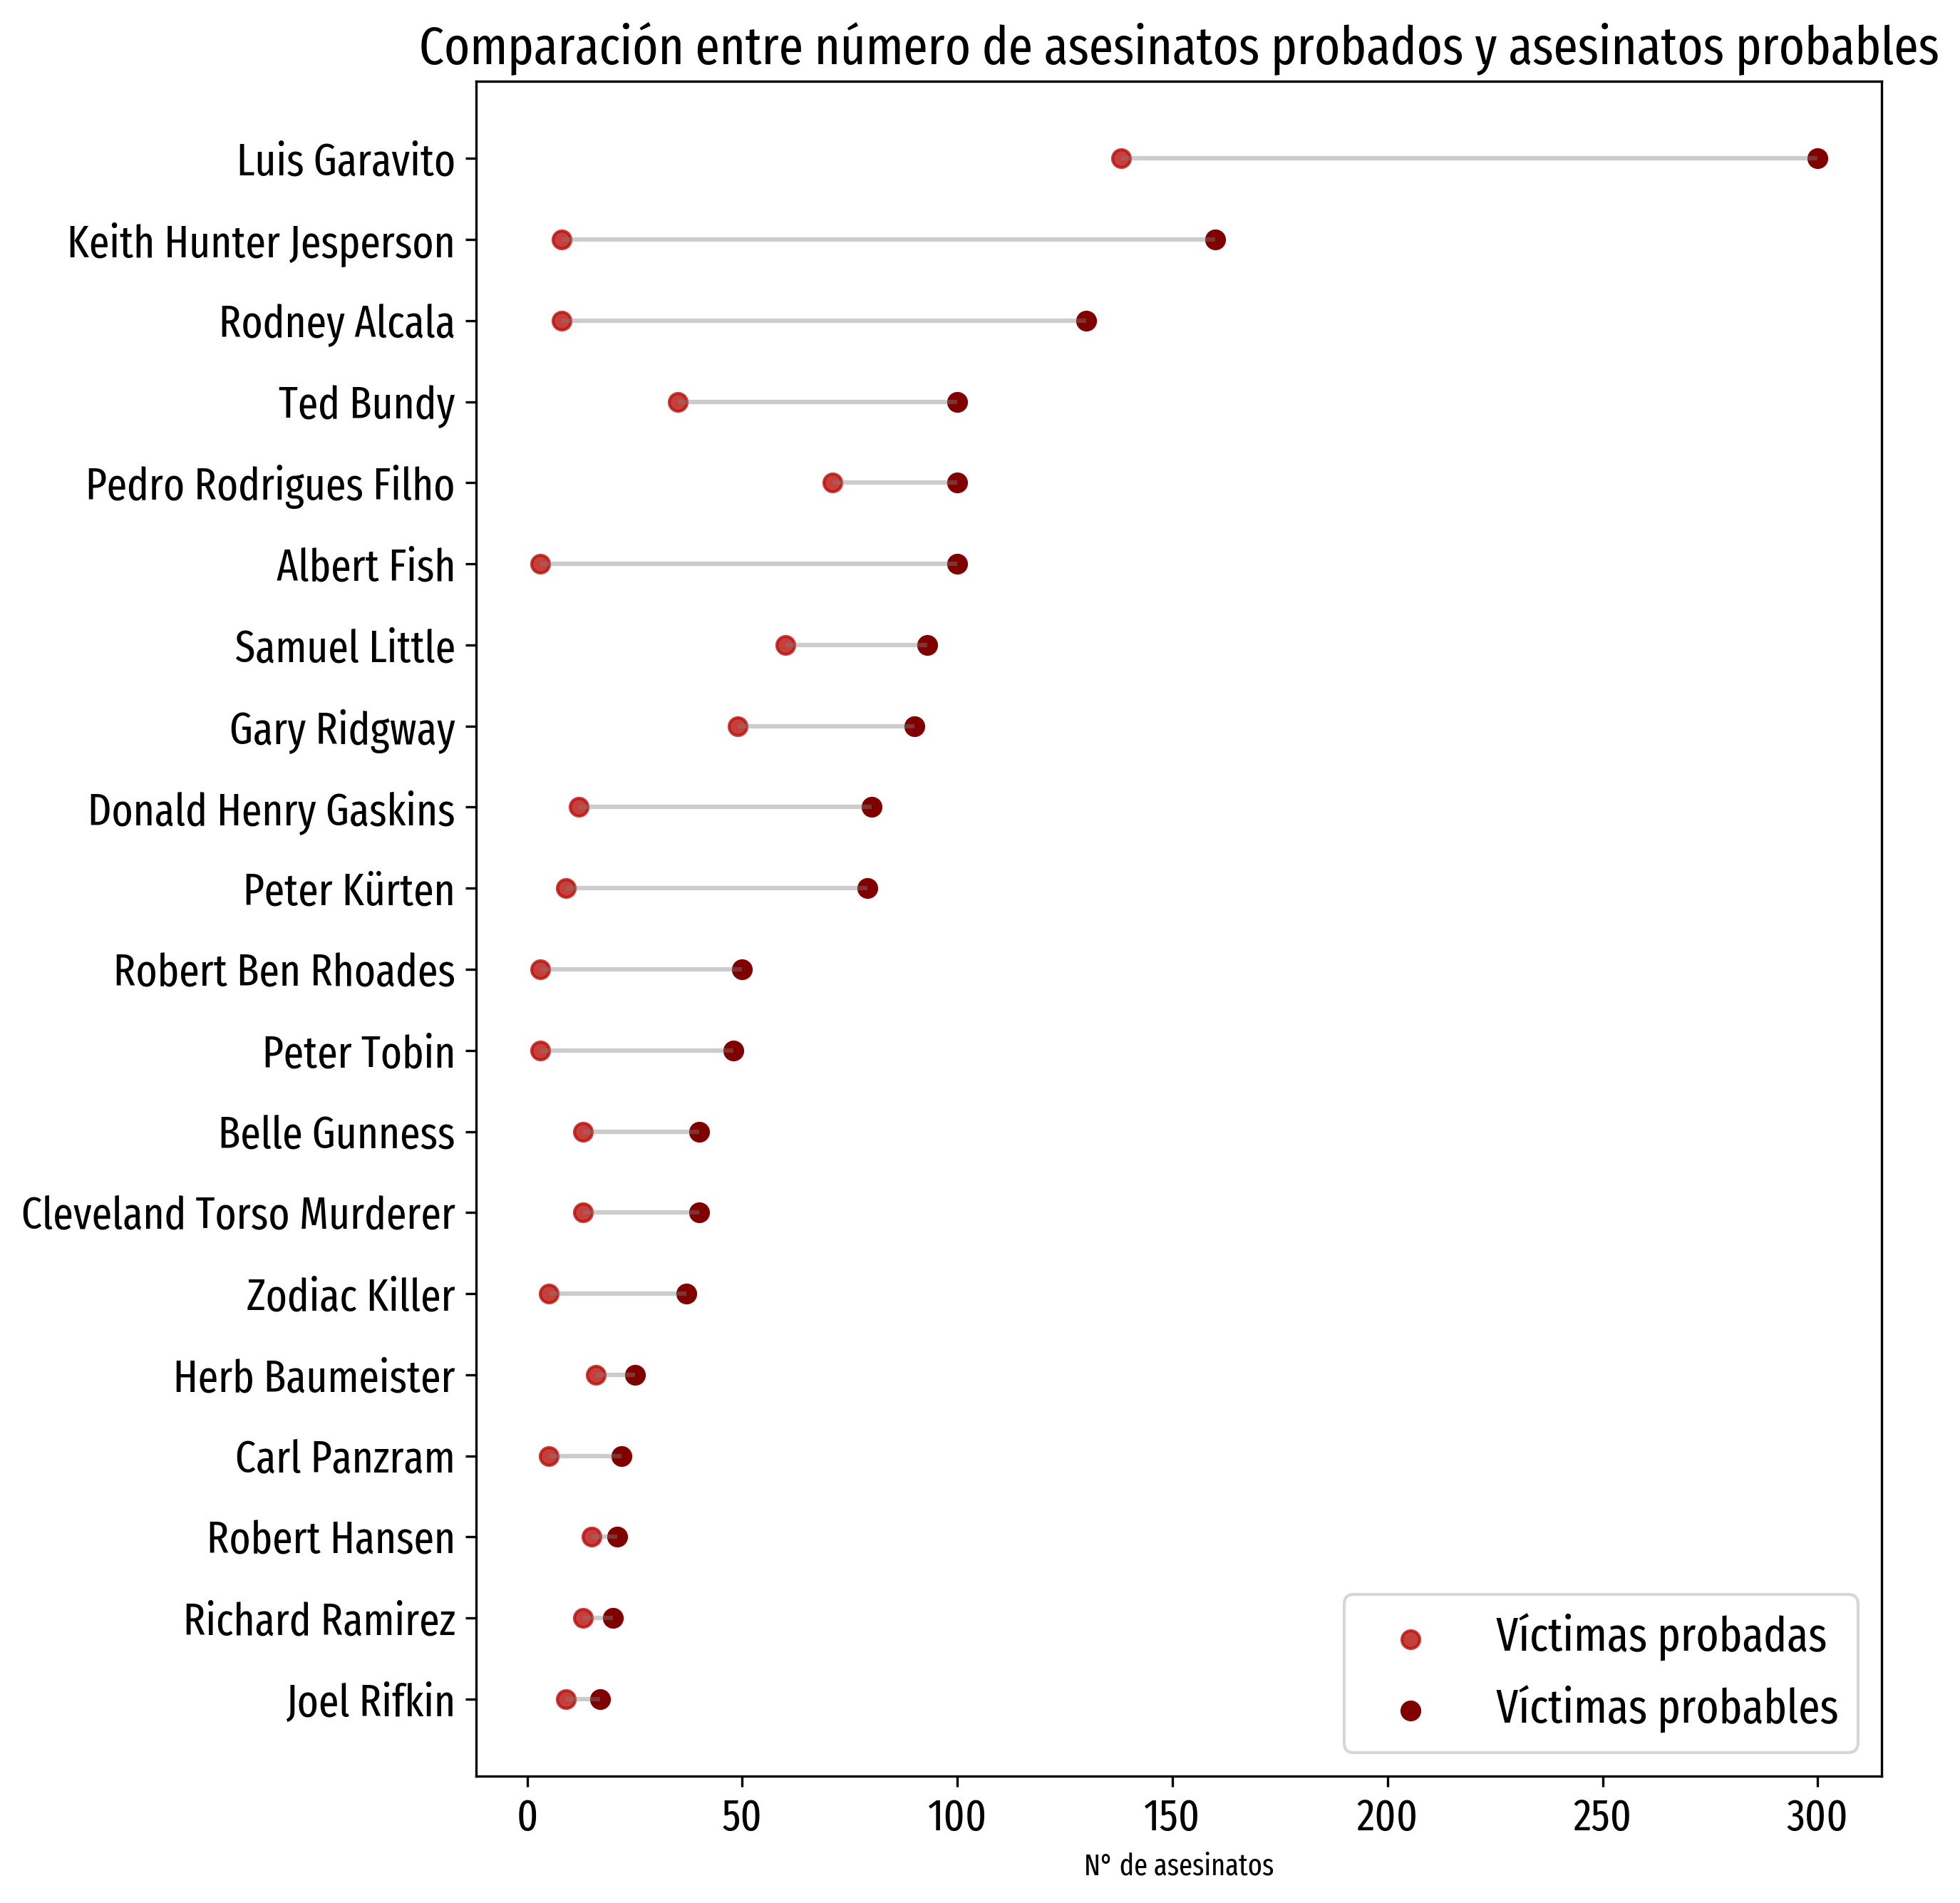

In [12]:
my_range=range(1,len(ts_2.index)+1)
 
# The horizontal plot is made using the hline function
plt.figure(figsize=(9,9))
plt.hlines(y=my_range, xmin=ts_2['proven_victims'], xmax=ts_2['possible_victims'], color='grey', alpha=0.4)
plt.scatter(ts_2['proven_victims'], my_range, color='#B80F0A', alpha=0.8, label='Víctimas probadas')
plt.scatter(ts_2['possible_victims'], my_range, color='#800000', alpha=1 , label='Víctimas probables')
plt.legend()
 
# Add title and axis names
plt.yticks(my_range, ts_2['Name'])
plt.title("Comparación entre número de asesinatos probados y asesinatos probables", loc='center')
plt.xlabel('N° de asesinatos')
plt.ylabel('')
plt.tight_layout()
plt.savefig("output/vis/lollypop.svg", transparent=True)